# Ejercicio 1

El siguiente código implementa un sistema de recomendación de películas. Ejecutar y analizar el código

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
from surprise import SVD, Reader
from surprise import Dataset
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

## Un recomendaror Simple (basado únicamente en ratings)

El Recomendador Simple ofrece recomendaciones generalizadas a cada usuario basadas en la popularidad de las películas y (a veces) en el género. La idea básica detrás de este recomendador es que las películas más populares y más aclamadas por la crítica tendrán una mayor probabilidad de ser del agrado del público promedio. Este modelo no ofrece recomendaciones personalizadas basadas en el usuario.

La implementación de este modelo es extremadamente trivial. Todo lo que tenemos que hacer es ordenar nuestras películas según las calificaciones y la popularidad, y mostrar las mejores películas de nuestra lista. Como un paso adicional, podemos pasar un argumento de género para obtener las mejores películas de un género en particular.

In [3]:
md = pd. read_csv('movies_metadata.csv')
md.head()

adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1  When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2  A family wedding reignites the ancient feud be...  ...   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4  Just when George Banks has recovered from his ...  ...   1995-02-10   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [4]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [5]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [6]:
m = vote_counts.quantile(0.95)
m

434.0

In [7]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [8]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [9]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [10]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)
qualified = qualified.sort_values('wr', ascending=False).head(250)


In [11]:
qualified.head(15)


title  year  vote_count  \
15480                                          Inception  2010       14075   
12481                                    The Dark Knight  2008       12269   
22879                                       Interstellar  2014       11187   
2843                                          Fight Club  1999        9678   
4863   The Lord of the Rings: The Fellowship of the Ring  2001        8892   
292                                         Pulp Fiction  1994        8670   
314                             The Shawshank Redemption  1994        8358   
7000       The Lord of the Rings: The Return of the King  2003        8226   
351                                         Forrest Gump  1994        8147   
5814               The Lord of the Rings: The Two Towers  2002        7641   
256                                            Star Wars  1977        6778   
1225                                  Back to the Future  1985        6239   
834                                        The Godfather  1972        6024   
1154                             The Empire Strikes Back  1980        5998   
46                                                 Se7en  1995        5915   

       vote_average  popularity  \
15480             8   29.108149   
12481             8  123.167259   
22879             8   32.213481   
2843              8   63.869599   
4863              8   32.070725   
292               8  140.950236   
314               8   51.645403   
7000              8   29.324358   
351               8   48.307194   
5814              8   29.423537   
256               8   42.149697   
1225              8   25.778509   
834               8   41.109264   
1154              8   19.470959   
46                8    18.45743   

                                                  genres        wr  
15480  [Action, Thriller, Science Fiction, Mystery, A...  7.917588  
12481                   [Drama, Action, Crime, Thriller]  7.905871  
22879                [Adventure, Drama, Science Fiction]  7.897107  
2843                                             [Drama]  7.881753  
4863                        [Adventure, Fantasy, Action]  7.871787  
292                                    [Thriller, Crime]  7.868660  
314                                       [Drama, Crime]  7.864000  
7000                        [Adventure, Fantasy, Action]  7.861927  
351                             [Comedy, Drama, Romance]  7.860656  
5814                        [Adventure, Fantasy, Action]  7.851924  
256                 [Adventure, Action, Science Fiction]  7.834205  
1225        [Adventure, Comedy, Science Fiction, Family]  7.820813  
834                                       [Drama, Crime]  7.814847  
1154                [Adventure, Action, Science Fiction]  7.814099  
46                            [Crime, Mystery, Thriller]  7.811669

In [12]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [13]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)

    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [14]:
build_chart('Romance').head(15)

title  year  vote_count  vote_average popularity  \
10309  Dilwale Dulhania Le Jayenge  1995         661             9  34.457024   
351                   Forrest Gump  1994        8147             8  48.307194   
876                        Vertigo  1958        1162             8   18.20822   
40251                   Your Name.  2016        1030             8  34.461252   
883               Some Like It Hot  1959         835             8  11.845107   
1132               Cinema Paradiso  1988         834             8  14.177005   
19901                     Paperman  2012         734             8   7.198633   
37863                  Sing Street  2016         669             8  10.672862   
882                  The Apartment  1960         498             8  11.994281   
38718               The Handmaiden  2016         453             8  16.727405   
3189                   City Lights  1931         444             8  10.891524   
24886             The Way He Looks  2014         262             8   5.711274   
45437               In a Heartbeat  2017         146             8   20.82178   
1639                       Titanic  1997        7770             7   26.88907   
19731      Silver Linings Playbook  2012        4840             7  14.488111   

             wr  
10309  8.565285  
351    7.971357  
876    7.811667  
40251  7.789489  
883    7.745154  
1132   7.744878  
19901  7.713951  
37863  7.689483  
882    7.599317  
38718  7.566166  
3189   7.558867  
24886  7.331363  
45437  7.003959  
1639   6.981546  
19731  6.970581

## Recomendador basado en contenido

El recomendador construido en la sección anterior tiene limitaciones importantes, como el hecho de dar las mismas recomendaciones a todos los usuarios, sin considerar sus gustos personales. Incluso si revisara los gráficos por género, no recibiría las mejores recomendaciones.

Para personalizar las recomendaciones, se construirá un sistema que calcule la similitud entre películas basándose en ciertos parámetros y sugiera películas similares a las que le gustaron a un usuario. Como utilizaremos los metadatos de las películas para construir este motor, se conoce como Filtrado Basado en Contenido. Se construirán dos recomendadores basados en contenido utilizando: descripciones y frases de las películas, y el elenco, equipo, palabras clave y género de las películas. Además, se usará un subconjunto de todas las películas disponibles debido a las limitaciones de potencia de cálculo.

In [15]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

md = md.drop([19730, 29503, 35587])

md['id'] = md['id'].astype('int')

smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 25)

In [16]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

### Recomendador Basado en Descripciones de Películas

Primero intentemos construir un recomendador utilizando las descripciones y las frases de las películas.

In [17]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2), min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [18]:
tfidf_matrix.shape


(9099, 268124)

In [19]:
# similaridad del coseno
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

cosine_sim[0]


array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

Ahora tenemos una matriz de similitud de coseno por pares para todas las películas en nuestro conjunto de datos. El siguiente paso es escribir una función que devuelva las 30 películas más similares basadas en la puntuación de similitud de coseno.

In [20]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [21]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Con la función implementada, se pueden calcular las distancias hacia las películas en base a su descripción, con un título de película

In [22]:
get_recommendations('The Godfather').head(10)


973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
Name: title, dtype: object

In [23]:
get_recommendations('The Dark Knight').head(10)


7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

## Recomendador Basado en Metadatos

Para construir nuestro recomendador de contenido estándar basado en metadatos, necesitaremos fusionar nuestro conjunto de datos actual con los conjuntos de datos del equipo y las palabras clave. Preparemos estos datos como nuestro primer paso.

In [24]:
keywords = pd.read_csv('keywords.csv')
credits = pd.read_csv('credits.csv')

In [25]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

In [26]:
md.shape

(45463, 25)

In [27]:
md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

In [28]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9219, 28)

Ahora tenemos nuestro elenco, equipo, géneros y créditos, todos en un solo dataset. Manipulemos esto un poco más usando las siguientes intuiciones:

Equipo: Del equipo, solo seleccionaremos al director como nuestra característica, ya que los demás no contribuyen tanto a la esencia de la película.

Elenco: Elegir el elenco es un poco más complicado. Los actores menos conocidos y los roles menores no afectan realmente la opinión de las personas sobre una película. Por lo tanto, solo debemos seleccionar a los personajes principales y sus respectivos actores. De manera arbitraria, elegiremos a los 3 actores principales que aparecen en la lista de créditos.

In [29]:
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [30]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [31]:
smd['director'] = smd['crew'].apply(get_director)


smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

 Se planeo crear un volcado de metadatos para cada película que consiste en géneros, director, actores principales y palabras clave. Luego, utilizar un Count Vectorizer para crear nuestra matriz de conteo, como hicimos en el Recomendador de Descripción. Los pasos restantes son similares a los que hicimos antes: calculamos las similitudes de coseno y devolvemos las películas que son más similares.

Estos son los pasos que sigo en la preparación de mis datos de géneros y créditos:

1. Eliminar espacios y convertir a minúsculas todas nuestras características. De esta manera, nuestro motor no confundirá entre Johnny Depp y Johnny Galecki.
2. Mencionar al director 3 veces para darle más peso en relación con todo el elenco.

In [32]:
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])

s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

Palabras Clave

Realizaremos una pequeña cantidad de preprocesamiento de nuestras palabras clave antes de usarlas. Como primer paso, calculamos los conteos de frecuencia de cada palabra clave que aparece en el conjunto de datos.

In [33]:
s = s.value_counts()
s[:5]

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

Eliminar palabras poco repetidas y realizar el proceso de steming

In [34]:
s = s[s > 1]

In [35]:
stemmer = SnowballStemmer('english')
stemmer.stem('dogs')

def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])


smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

get_recommendations('The Dark Knight').head(10)


8031         The Dark Knight Rises
6218                 Batman Begins
6623                  The Prestige
2085                     Following
7648                     Inception
4145                      Insomnia
3381                       Memento
8613                  Interstellar
7659    Batman: Under the Red Hood
1134                Batman Returns
Name: title, dtype: object

Reutilizaremos la función get_recommendations que escribimos anteriormente. Dado que nuestras puntuaciones de similitud de coseno han cambiado, esperamos obtener resultados diferentes (y probablemente mejores). Verifiquemos con "The Dark Knight" nuevamente y veamos qué recomendaciones obtengo esta vez.

In [36]:
def improved_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]

    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [37]:
improved_recommendations('The Dark Knight')


title  vote_count  vote_average  year  \
7648                           Inception       14075             8  2010   
8613                        Interstellar       11187             8  2014   
6623                        The Prestige        4510             8  2006   
3381                             Memento        4168             8  2000   
8031               The Dark Knight Rises        9263             7  2012   
6218                       Batman Begins        7511             7  2005   
1134                      Batman Returns        1706             6  1992   
132                       Batman Forever        1529             5  1995   
9024  Batman v Superman: Dawn of Justice        7189             5  2016   
1260                      Batman & Robin        1447             4  1997   

            wr  
7648  7.917588  
8613  7.897107  
6623  7.758148  
3381  7.740175  
8031  6.921448  
6218  6.904127  
1134  5.846862  
132   5.054144  
9024  5.013943  
1260  4.287233

## Ejercicio

Pruebe distintas películas y verifique si los resultados son suficientemente racionales

In [63]:
# inserte su código aquí

display(improved_recommendations('The Dark Knight'))



title  vote_count  vote_average  year  \
7648                           Inception       14075             8  2010   
8613                        Interstellar       11187             8  2014   
6623                        The Prestige        4510             8  2006   
3381                             Memento        4168             8  2000   
8031               The Dark Knight Rises        9263             7  2012   
6218                       Batman Begins        7511             7  2005   
1134                      Batman Returns        1706             6  1992   
132                       Batman Forever        1529             5  1995   
9024  Batman v Superman: Dawn of Justice        7189             5  2016   
1260                      Batman & Robin        1447             4  1997   

            wr  
7648  7.917588  
8613  7.897107  
6623  7.758148  
3381  7.740175  
8031  6.921448  
6218  6.904127  
1134  5.846862  
132   5.054144  
9024  5.013943  
1260  4.287233

In [64]:
display(improved_recommendations('Avatar'))


title  vote_count  vote_average  year        wr
1376                     Titanic        7770             7  1997  6.907153
8658  X-Men: Days of Future Past        6155             7  2014  6.884396
8401     Star Trek Into Darkness        4479             7  2013  6.844959
522   Terminator 2: Judgment Day        4274             7  1991  6.838208
1011              The Terminator        4208             7  1984  6.835908
974                       Aliens        3282             7  1986  6.795018
922                    The Abyss         822             7  1989  6.393539
8419                Man of Steel        6462             6  2013  5.952478
344                    True Lies        1138             6  1994  5.791530
8724           Jupiter Ascending        2816             5  2015  5.032703

## Filtrado Colaborativo

Nuestro motor basado en contenido tiene algunas limitaciones importantes. Solo es capaz de sugerir películas que están cerca de una cierta película. Es decir, no es capaz de captar gustos y proporcionar recomendaciones a través de géneros.

Además, el motor que construimos no es realmente personal ya que no captura los gustos y sesgos personales de un usuario. Cualquier persona que consulte nuestro motor para recomendaciones basadas en una película recibirá las mismas recomendaciones para esa película, independientemente de quién sea.

Por lo tanto, en esta sección, utilizaremos una técnica llamada Filtrado Colaborativo para hacer recomendaciones a los espectadores de películas. El Filtrado Colaborativo se basa en la idea de que los usuarios similares pueden ser utilizados para predecir cuánto me gustará un producto o servicio que esos usuarios han utilizado/experimentado, pero que yo no he probado.

No se implementará el Filtrado Colaborativo desde cero. En su lugar, se utilizará la biblioteca Surprise que emplea algoritmos extremadamente poderosos como la Descomposición en Valores Singulares (SVD) para minimizar el RMSE (Error Cuadrático Medio) y proporcionar excelentes recomendaciones.

In [39]:
reader = Reader()

ratings = pd.read_csv('ratings_small.csv')
ratings.head()

userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205

In [40]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8995  0.8988  0.8936  0.8971  0.8968  0.8972  0.0020  
MAE (testset)     0.6938  0.6924  0.6879  0.6906  0.6898  0.6909  0.0020  
Fit time          0.75    0.76    0.76    0.76    0.76    0.76    0.01    
Test time         0.09    0.09    0.09    0.09    0.20    0.11    0.05    


{'test_rmse': array([0.89947072, 0.89878884, 0.89359134, 0.89714461, 0.89677263]),
 'test_mae': array([0.69376478, 0.69239582, 0.68788501, 0.69059722, 0.68976558]),
 'fit_time': (0.7475285530090332,
  0.7604410648345947,
  0.7635884284973145,
  0.7585639953613281,
  0.7555606365203857),
 'test_time': (0.08868813514709473,
  0.09087371826171875,
  0.08912181854248047,
  0.09238982200622559,
  0.20365262031555176)}

In [41]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [42]:
ratings[ratings['userId'] == 1]

userId  movieId  rating   timestamp
0        1       31     2.5  1260759144
1        1     1029     3.0  1260759179
2        1     1061     3.0  1260759182
3        1     1129     2.0  1260759185
4        1     1172     4.0  1260759205
5        1     1263     2.0  1260759151
6        1     1287     2.0  1260759187
7        1     1293     2.0  1260759148
8        1     1339     3.5  1260759125
9        1     1343     2.0  1260759131
10       1     1371     2.5  1260759135
11       1     1405     1.0  1260759203
12       1     1953     4.0  1260759191
13       1     2105     4.0  1260759139
14       1     2150     3.0  1260759194
15       1     2193     2.0  1260759198
16       1     2294     2.0  1260759108
17       1     2455     2.5  1260759113
18       1     2968     1.0  1260759200
19       1     3671     3.0  1260759117

In [43]:
svd.predict(1, 302, 3)

Prediction(uid=1, iid=302, r_ui=3, est=2.723785198902673, details={'was_impossible': False})

Para la película con ID 302, obtenemos una predicción estimada de 2.686. Este sistema de recomendación es no le importa qué película es (o qué contiene). Funciona puramente en función de un ID de película asignado y trata de predecir calificaciones basándose en cómo otros usuarios han calificado la película.

In [44]:
import numpy as np
import pandas as pd
import statsmodels.stats.contingency_tables as d


In [45]:
table = np.asarray([[7, 6], [1, 2]])

In [46]:
print(table)

[[7 6]
 [1 2]]


In [47]:
print(d.mcnemar(table))

pvalue      0.125
statistic   1.0


In [48]:
from sklearn.metrics import confusion_matrix
# vector real
real = [1,1,1,1,1,1,1,0,0,0,0,0,0]
a = [1,1,1,1,1,1,1,0,0,0,0,0,0]
b = [1,1,0,0,1,1,0,0,1,0,0,0,0]
c1 = [1,1,1,1,1,1,1,1,1,1,1,1,0]
c2 = [1,1,1,1,0,1,0,0,1,0,0,0,0]
c3 = [1,1,1,0,0,1,0,0,0,0,0,0,0]

In [49]:
confusion_matrix(real,a)

array([[6, 0],
       [0, 7]], dtype=int64)

In [50]:
s = np.transpose(confusion_matrix(real,a))
s

array([[6, 0],
       [0, 7]], dtype=int64)

In [51]:
print(confusion_matrix(real,a).T)
print(confusion_matrix(real,b).T)
print(confusion_matrix(real,c1).T)
print(confusion_matrix(real,c2).T)
print(confusion_matrix(real,c3).T)

[[6 0]
 [0 7]]
[[5 3]
 [1 4]]
[[1 0]
 [5 7]]
[[5 2]
 [1 5]]
[[6 3]
 [0 4]]


In [52]:
r_a = confusion_matrix(real,a).T
r_b = confusion_matrix(real,b).T
r_c1 = confusion_matrix(real,c1).T
r_c2 = confusion_matrix(real, c2).T
r_c3 = confusion_matrix(real, c3).T


In [53]:
def obtener_tpr_fpr(matrix):
    # print(matrix)
    # print(matrix.flatten())
    a, b, c, d = matrix.flatten()
    tpr = a / (a + c)
    fpr = (b / (b + d))
    return [tpr, fpr]

In [54]:
obtener_tpr_fpr(r_b) 

[0.8333333333333334, 0.42857142857142855]

In [55]:
puntos = obtener_tpr_fpr(r_a) + obtener_tpr_fpr(r_b) + obtener_tpr_fpr(r_c1) + obtener_tpr_fpr(r_c2) +obtener_tpr_fpr(r_c3)


In [56]:
puntos

[1.0,
 0.0,
 0.8333333333333334,
 0.42857142857142855,
 0.16666666666666666,
 0.0,
 0.8333333333333334,
 0.2857142857142857,
 1.0,
 0.42857142857142855]

In [57]:
import matplotlib as plt
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_xlabel("False Positive Rate", fontsize = 15)
ax.set_ylabel("True Positive Rate", fontsize = 15)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
sns.scatterplot(x =  puntos[::2], y =  puntos[1::2], s = 50);
for i in range(len(t)):
    plt.text(puntos[::2] + 0.02, puntos[1::2] - 0.03, t[i], color = "red", fontsize = 15)

AttributeError: module 'matplotlib' has no attribute 'subplots'

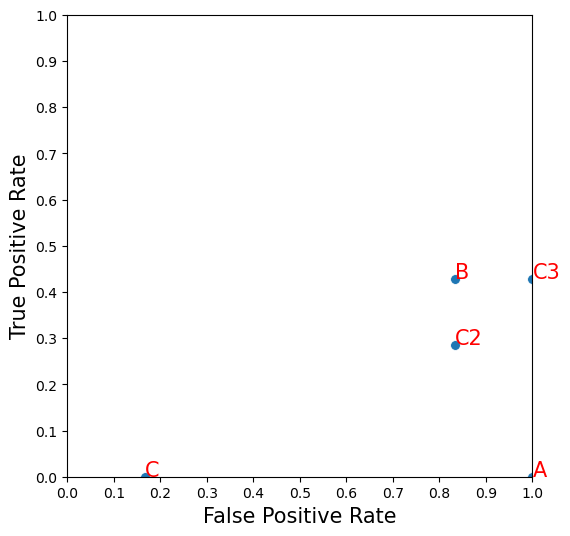

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

t = ["A", "B", "C", "C2", "C3"]  # Etiquetas de ejemplo

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlabel("False Positive Rate", fontsize=15)
ax.set_ylabel("True Positive Rate", fontsize=15)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

sns.scatterplot(x=puntos[::2], y=puntos[1::2], s=50, ax=ax)

for i in range(len(t)):
    plt.text(puntos[2*i], puntos[2*i+1], t[i], color="red", fontsize=15)

plt.show()


FP: 0 TP: 7
FP: 1 TP: 4
FP: 5 TP: 7
FP: 1 TP: 5
FP: 0 TP: 4


In [ ]:
t = ["0", "0.8", "-0.5"]
fig, ax = plt.subplots(figsize = (6, 6))
ax.set_xlabel("False Positive Rate", fontsize = 15)
ax.set_ylabel("True Positive Rate", fontsize = 15)
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
sns.scatterplot(x = FPRs, y = TPRs, s = 50);
for i in range(len(t)):
    plt.text(FPRs[i] + 0.02, TPRs[i] - 0.03, t[i], color = "red", fontsize = 15)